In [1]:
import snapatac2 as snap
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from CAMUS import CAMUS_score, CAMUS_prioritize, precluster_scATAC

import warnings
warnings.filterwarnings("ignore")

## 1. We first load the annotated adata (the PBMC scATAC-seq data)

In [3]:
adata_raw = sc.read_h5ad('../data/ATAC_PBMC_annotated.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'leiden', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'scANVI', 'scJoint', 'Seurat', 'scDART', 'GLUE'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'count', 'selected'
    uns: 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

We have the maual annotation in 'cell_type' and the annotation results from four different methods, i.e., scANVI, scJoint, Seurat, scDART and GLUE.

## 2. We then preprocess the data and then performed pre-clustering

For the scATAC-seq datasets, we used 'precluster_scATAC' function.

In [4]:
adata = precluster_scATAC(adata_raw.copy(), resolution=0.7)

2024-09-28 02:56:24 - INFO - Selected 106124 features.


The resolution parameter controls the number of clusters, with a default value of 0.7. You can visualize the clustering results and the annotation results on the UMAP to guide the selection of this parameter. Also, an appropriate resolution should result in a number of clusters that closely matches the number of cell types from the reference dataset.

## 3. We next calculate the CAMUS score for each method, and then prioritize them

In [5]:
prioritized_dict = CAMUS_prioritize(adata, key_class=['scANVI', 'scJoint', 'Seurat', 'scDART', 'GLUE'])
prioritized_dict

{'GLUE': 0.8381990150773703,
 'Seurat': 0.8053886318991251,
 'scJoint': 0.7869767508247902,
 'scANVI': 0.7401971501096948,
 'scDART': 0.7184701148534045}

## 4. Here we have the manual annotation for this data, so we can compare the CAMUS score and the annotation accurcay

In [7]:
# Use acc_dict to score the annotation accuracy
acc_dict = {}
for ele in ['GLUE','Seurat', 'scJoint','scANVI', 'scDART']:
    accuracy = np.mean(adata.obs['cell_type'].astype(str) == adata.obs[ele].astype(str))
    acc_dict[ele] = accuracy
acc_dict

{'GLUE': 0.9171425604817776,
 'Seurat': 0.9119509915896584,
 'scJoint': 0.817464437753089,
 'scANVI': 0.7303499117433289,
 'scDART': 0.6451043505347316}

In [9]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

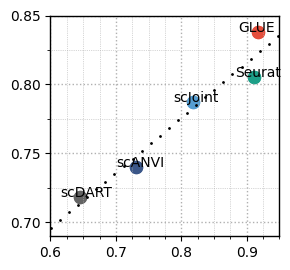

In [15]:
# Plot scatterplot of acc and CAMUS socre
acc = list(acc_dict.values())
CAMUS_score = list(prioritized_dict.values())
methods = list(prioritized_dict.keys())

# Create a scatter plot
plt.figure(figsize=(3, 2.8))

colors = ['#e44e3c', '#1d9f88','#569ed2', '#3b5789','#646464']
# Calculate the regression line
slope, intercept = np.polyfit(acc, CAMUS_score, 1)
x_vals = np.linspace(min(acc)-0.1, max(acc)+0.1, 35)  # Generate more points for a denser set
y_vals = intercept + slope * x_vals

plt.yticks([0.60, 0.70, 0.80, 0.90])
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.FixedLocator([min(acc), (min(acc)+max(acc))/2, max(acc)]))  # Set major ticks for x-axis
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(6))  # Add 6 minor ticks between each major tick on x-axis
ax.yaxis.set_major_locator(ticker.FixedLocator([0.70, 0.75, 0.80, 0.85]))  # Set major ticks for y-axis
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Add 2 minor ticks between each major tick on y-axis

# Set the x-axis ticks, retaining three major ticks
plt.xticks([0.65, 0.75, 0.85, 0.95])
# Plot the regression line as points
plt.plot(x_vals, y_vals, linestyle='None', marker='o', color='black', markersize=1) 

# Set grid lines, retaining more vertical grid lines
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.FixedLocator([0.60, 0.70, 0.80, 0.90]))  # Set major ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # Add 4 minor ticks between each major tick

plt.grid(True, which='both', axis='both')  # Show both major and minor grid lines
plt.xlim(0.60, 0.95)
plt.ylim(0.69, 0.85)
ax.grid(True, which='major', linestyle=':', linewidth=1.0)  # Make major grid lines thicker
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)  # Make minor grid lines thinner

# Increase border thickness
for spine in ax.spines.values():
    spine.set_linewidth(1.0)

# Scatter points for each category
for i, category in enumerate(methods):
    plt.scatter(acc[i], CAMUS_score[i], color=colors[i], label=category, s=75)

# Scatter points for each category with labels
for i, category in enumerate(methods):
    plt.scatter(acc[i], CAMUS_score[i], color=colors[i], label=category, s=75)
    plt.text(acc[i] - 0.03, CAMUS_score[i], category, fontsize=10)  # Adjust position as needed

plt.tight_layout()  # Adjust layout to fit all elements
# Show the plot
plt.show()
